In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import time
plt.style.use('seaborn-notebook')
%matplotlib inline

# JUST TO MAKE SURE SOME WARNINGS ARE IGNORED 
import warnings
warnings.filterwarnings("ignore")

In [14]:
import numpy as np
from logging import getLogger

logger = getLogger(__name__)


class DECore(object):
    """
    Core Class of Differential Evolution
    """

    def __init__(self,
                 objective_function: callable,
                 ndim: int,
                 lower_limit: np.ndarray,
                 upper_limit: np.ndarray,
                 minimize: bool = True):

        """
        :param objective_function: f(x) callable function
        :param ndim: dimension of x
        :param lower_limit: lower limit of search space 1d-array
        :param upper_limit: upper limit of search space 1d-array
        :param minimize: minimize flag. if the problem is minimization, then set True.
                                        otherwise set False and turning as maximization.
        """
        self._of = objective_function
        self._pop = None
        self._nd = ndim
        self._x_current = None
        self._low_lim = lower_limit
        self._up_lim = upper_limit
        self._f_current = None
        self._is_minimize = minimize
        self._orbit = None

    def initialization(self, x_init=None):
        """
        :param x_init: initial value of x (optional)
        :return:
        """
        # initialize x
        if x_init:
            self._x_current = x_init
        else:
            self._x_current = np.random.rand(self._pop, self._nd) * (self._up_lim - self._low_lim) + self._low_lim

        # initialize orbit
        self._orbit = []

    def _selection(self, **kwargs):

        pass

    def _mutation(self, **kwargs):

        pass

    def _crossover(self, **kwargs):

        pass

    def _mutation_crossover(self, **kwargs):

        pass

    def _evaluate_with_check(self, x):
        if np.any(x < self._low_lim) or np.any(x > self._up_lim):
            return np.inf if self._is_minimize else -np.inf
        else:
            try:
                f = self._of(x)
            except Exception as ex:
                logger.error(ex)
                f = np.inf if self._is_minimize else -np.inf
            return f

    def _evaluate(self, params):
        current, u = params
        return current, self._evaluate_with_check(u)

    def optimize_mp(self, **kwargs):

        pass

    def optimize(self, **kwargs):

        pass

    @property
    def orbit(self):
        return self._orbit

In [15]:
import numpy as np
from concurrent import futures
from logging import getLogger

logger = getLogger(__name__)


class DE(DECore):
    """
    Differential Evolution
    """

    def __init__(self,
                 objective_function: callable,
                 ndim: int,
                 lower_limit: np.ndarray,
                 upper_limit: np.ndarray,
                 minimize: bool = True):
        """
        :param objective_function: f(x) callable function
        :param ndim: dimension of x
        :param lower_limit: lower limit of search space 1d-array
        :param upper_limit: upper limit of search space 1d-array
        :param minimize: minimize flag. if the problem is minimization, then set True.
                                        otherwise set False and turning as maximization.
        """

        super(DE, self).__init__(objective_function=objective_function,
                                 ndim=ndim,
                                 lower_limit=lower_limit,
                                 upper_limit=upper_limit,
                                 minimize=minimize)

    def _selection(self, p, u):
        """
        :param p: current index
        :param u: trial vectors
        :return:
        """

        fu = self._evaluate_with_check(u)

        # score is better than current
        q1 = fu <= self._f_current[p] if self._is_minimize else fu >= self._f_current[p]
        # over lower limit
        q2 = np.any(u < self._low_lim)
        # over upper limit
        q3 = np.any(u > self._up_lim)
        # q1 ^ ~q2 ^ ~q3
        q = q1 * ~q2 * ~q3

        f_p1 = fu if q else self._f_current[p]
        x_p1 = u if q else self._x_current[p]
        return p, f_p1, x_p1

    def _mutation(self, current, mutant, num, sf):
        """
        :param current: current index of population
        :param mutant: mutation method
        :param num: number of mutant vectors
        :param sf: scaling factor
        :return:
        """

        assert num > 0, "'num' must be greater than 0."

        # mutant vector
        # best
        if mutant == 'best':
            r_best = np.argmin(self._f_current) if self._is_minimize else np.argmax(self._f_current)
            r = [r_best]
            r += np.random.choice([n for n in range(self._pop) if n != r_best], 2 * num, replace=False).tolist()
            v = self._x_current[r[0]] \
                + sf * np.sum([self._x_current[r[m + 1]] - self._x_current[r[m + 2]] for m in range(num)], axis=0)

        # rand
        elif mutant == 'rand':
            r = np.random.choice(range(self._pop), 2 * num + 1, replace=False).tolist()
            v = self._x_current[r[0]] \
                + sf * np.sum([self._x_current[r[m + 1]] - self._x_current[r[m + 2]] for m in range(num)], axis=0)

        # current-to-rand
        elif mutant == 'current-to-rand':
            r = [current]
            r += np.random.choice([n for n in range(self._pop) if n != current], 2 * num + 1, replace=False).tolist()
            v = self._x_current[r[0]] \
                + sf * (self._x_current[r[1]] - self._x_current[r[0]]) \
                + sf * np.sum([self._x_current[r[m + 2]] - self._x_current[r[m + 3]] for m in range(num)], axis=0)

        # current-to-best
        elif mutant == 'current-to-best':
            r_best = np.argmin(self._f_current) if self._is_minimize else np.argmax(self._f_current)
            r = [r_best, current]
            r += np.random.choice([
                n for n in range(self._pop) if n not in [r_best, current]], 2 * num, replace=False).tolist()
            v = self._x_current[r[0]] \
                + sf * (self._x_current[r[1]] - self._x_current[r[0]]) \
                + sf * np.sum([self._x_current[r[m + 2]] - self._x_current[r[m + 3]] for m in range(num)], axis=0)

        else:
            raise ValueError('invalid `mutant`: {}'.format(mutant))

        return v

    def _crossover(self, v, x, cross, cr):
        """
        :param v: mutant vector
        :param x: current vector
        :param cross: crossover method
        :param cr: crossover-rate
        :return:
        """
        # crossover
        r = np.random.choice(range(self._nd))
        u = np.zeros(self._nd)

        # binary crossover
        if cross == 'bin':
            flg = np.equal(r, np.arange(self._nd)) + np.random.rand(self._nd) < cr

        # exponential crossover
        elif cross == 'exp':
            flg = np.array([False for _ in range(self._nd)])
            for l in range(self._nd):
                flg[r] = True
                r = (r + 1) % self._nd
                if np.random.rand() >= cr:
                    break
        else:
            raise ValueError('invalid `cross`: {}'.format(cross))

        # from mutant vector
        u[flg] = v[flg]
        # from current vector
        u[~flg] = x[~flg]

        return u

    def _mutation_crossover(self, mutant, num, sf, cross, cr):
        l_up = []
        # for each individuals
        for p in range(self._pop):
            # mutation
            v_p = self._mutation(p, mutant=mutant, num=num, sf=sf)

            # crossover
            u_p = self._crossover(v_p, self._x_current[p], cross=cross, cr=cr)
            l_up.append(u_p)

        return l_up

    def optimize_mp(self,
                    k_max: int,
                    population: int = 5,
                    mutant: str = 'best',
                    num: int = 1,
                    cross: str = 'bin',
                    sf: float = 0.7,
                    cr: float = 0.3,
                    proc: [int, None] = None):
        """
        :param k_max: max-iterations
        :param population: number of populations
        :param mutant: mutation method ['best', 'rand', 'current-to-best', 'current-to-rand']
        :param num: number of mutant vectors
        :param cross: crossover method ['bin', 'exp']
        :param sf: scaling-factor F
        :param cr: crossover-rate CR
        :param proc: number of process. if None, then use maximum process
        :return:
        ex) DE/rand/1/bin --> method='rand', num=1, cross='bin'
            DE/best/2/exp --> method='best', num=2, cross='exp'
        """
        # set population
        self._pop = population

        # initialize
        self.initialization()

        # get fitness of initial x
        with futures.ProcessPoolExecutor(proc) as executor:
            results = executor.map(self._evaluate, zip(range(self._pop), self._x_current))
   
        self._f_current = np.array([r[1] for r in sorted(list(results))])

        for k in range(k_max):
            # mutation and crossover
            l_up = self._mutation_crossover(mutant, num, sf, cross, cr)

            # multi-processing
            with futures.ProcessPoolExecutor(proc) as executor:
                results = executor.map(self._selection, range(self._pop), l_up)

            # correct results
            _x_current = []
            _f_current = []
            for _, fp, x in sorted(results):
                _x_current.append(x)
                _f_current.append(fp)

            # update current values
            self._x_current = np.r_[_x_current].copy()
            self._f_current = np.array(_f_current).copy()

            best_score = np.amin(self._f_current) if self._is_minimize else np.amax(self._f_current)
            logger.info('k={} best score = {}'.format(k, best_score))
            self._orbit.append(best_score)

        # get best point
        best_idx = np.argmin(self._f_current) if self._is_minimize else np.argmax(self._f_current)
        x_best = self._x_current[best_idx]
        logger.info('global best score = {}'.format(self._f_current[best_idx]))
        logger.info('x_best = {}'.format(x_best))
        
        return x_best

    def optimize(self,
                 k_max: int,
                 population: int = 20,
                 mutant: str = 'best',
                 num: int = 1,
                 cross: str = 'bin',
                 sf: float = 0.7,
                 cr: float = 0.3):
        """
        :param k_max: max-iterations
        :param population: number of populations
        :param mutant: mutation method ['best', 'rand', 'current-to-best', 'current-to-rand']
        :param num: number of mutant vectors
        :param cross: crossover method ['bin', 'exp']
        :param sf: scaling-factor F
        :param cr: crossover-rate CR
        :return:
        ex) DE/rand/1/bin --> method='rand', num=1, cross='bin'
            DE/best/2/exp --> method='best', num=2, cross='exp'
        """
        # set population
        self._pop = population

        # initialize
        self.initialization()

        # get fitness of initial x
        self._f_current = np.array([self._evaluate_with_check(x) for x in self._x_current])

        for k in range(k_max):
            # mutation and crossover
            l_up = self._mutation_crossover(mutant, num, sf, cross, cr)

            for p, u_p in enumerate(l_up):
                # selection
                _, f_p1, x_p1 = self._selection(p, u_p)

                # update current values
                self._f_current[p] = f_p1
                self._x_current[p] = x_p1

            best_score = np.amin(self._f_current) if self._is_minimize else np.amax(self._f_current)
            logger.info('k={} best score = {}'.format(k, best_score))
            self._orbit.append(best_score)

        # get best point
        best_idx = np.argmin(self._f_current) if self._is_minimize else np.argmax(self._f_current)
        x_best = self._x_current[best_idx]
        logger.info('global best score = {}'.format(self._f_current[best_idx]))
        logger.info('x_best = {}'.format(x_best))
        return x_best

In [16]:
Ag_data = pd.read_csv('Ag_ordered_dataset.csv',  index_col = 0)
shape_set = Ag_data['Shape'].unique()

# Use label encoder to transform the label shape
le = preprocessing.LabelEncoder()
le.fit(shape_set)
normalised_shape = le.transform(Ag_data['Shape']) 

Ag_data['Shape'] = normalised_shape

In [17]:
X = Ag_data.iloc[:, :79]
y = Ag_data['Shape']
y = np.array(y)
X = np.array(X)

In [18]:
from sklearn.datasets import load_digits
dataset = load_digits()
print(dataset.target)

[0 1 2 ... 8 9 8]


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.1)

In [20]:
import numpy as np
from sklearn.model_selection import KFold
from tempfile import TemporaryDirectory
import joblib
from pathlib import Path
from logging import getLogger, basicConfig

logger = getLogger(__name__)


class HyperTuner(object):
    def __init__(self, model, space: dict, k_fold: int = 5, **params):
        """
        :param model: target model
        :param space: search space
        :param k_fold: number of folders for K-fold CV
        :param params: parameters for optimizer
        space = {
            'parameter': {'scale': linear', 'range': [0, 1.5]},
            'parameter': {'scale': 'log', 'range': [-1, 2]},
            'parameter': {'scale': 'category', 'range': ['a', 'b', 'c']},
            'parameter': {'scale': 'integer', 'range': [0, 10]},
            'parameter': 'static'
        }
        """
        self._model = model
        assert isinstance(space, dict)
        self._space = space
        self._parameters = list(self._space.keys())
        self._static_params = [p for p in self._parameters if not isinstance(self._space[p], dict)]
        self._variable_params = [p for p in self._parameters if isinstance(self._space[p], dict)]
        self._tempdir = TemporaryDirectory()
        self._tempfile = Path(self._tempdir.name + 'temp_data.gz')
        self._eval_function = None
        default_opt_param = {'k_max': 50,
                             'population': 10,
                             'mutant': 'best',
                             'num': 1,
                             'cross': 'bin',
                             'sf': 0.7,
                             'cr': 0.4}
        self._optimizer_param = default_opt_param
        self._optimizer_param.update(params)
        self._kf = k_fold

    def __del__(self):
        self._tempdir.cleanup()

    def _get_search_limits(self):
        lowers = []
        uppers = []
        for k in self._variable_params:
            if self._space[k]['scale'] in ['linear', 'log']:
                lowers.append(self._space[k]['range'][0])
                uppers.append(self._space[k]['range'][1])
            elif self._space[k]['scale'] == 'integer':
                lowers.append(self._space[k]['range'][0])
                uppers.append(self._space[k]['range'][1] + 1)
            else:
                lowers.append(0)
                uppers.append(len(self._space[k]['range']))

        return np.array(lowers), np.array(uppers)

    def _translate_to_origin(self, x):
        org_x = {}
        for n, k in enumerate(self._variable_params):
            if self._space[k]['scale'] == 'log':
                org_x[k] = np.power(10, x[n])
            elif self._space[k]['scale'] == 'category':
                org_x[k] = self._space[k]['range'][int(x[n])]
            elif self._space[k]['scale'] == 'integer':
                org_x[k] = int(x[n])
            else:
                org_x[k] = x[n]

        # static parameters
        for k in self._static_params:
            org_x[k] = self._space[k]
        return org_x

    def _evaluate(self, x):
        # load data from temporary directory
        input_data, targets = joblib.load(self._tempfile)

        # set model using parameter x
        param = self._translate_to_origin(x)
        model = self._model.set_params(**param)

        # train model using CV (K-fold)
        skf = KFold(n_splits=self._kf, shuffle=True)
        scores = []
        for train, test in skf.split(input_data, targets):
            x_tr, t_tr = input_data[train], targets[train]
            x_te, t_te = input_data[test], targets[test]

            model.fit(x_tr, t_tr)
            scores.append(self._eval_function(y_pred=model.predict(x_te), y_true=t_te))

        # average score
        return np.average(scores)

    def tuning(self, eval_function: callable, x: np.ndarray, t: np.ndarray, minimize: bool = True):
        joblib.dump((x, t), self._tempfile)

        # set DE
        lower_limit, upper_limit = self._get_search_limits()

        # set evaluation function
        self._eval_function = eval_function
        optimizer = DE(objective_function=self._evaluate, ndim=len(lower_limit), lower_limit=lower_limit,
                       upper_limit=upper_limit, minimize=minimize)

        x_best = optimizer.optimize_mp(**self._optimizer_param)

        return self._translate_to_origin(x_best)


if __name__ == '__main__':
    basicConfig(level='INFO')

    from sklearn.datasets import load_digits
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score

    search_space = {
        'max_depth': {'scale': 'integer', 'range': [1, 10]},
        'min_samples_split': {'scale': 'integer', 'range': [2, 10]},
        'min_samples_leaf': {'scale': 'integer', 'range': [1, 10]},
        'max_features': {'scale': 'category', 'range': ['auto', 'sqrt', 'log2', None]}
    }

    tuner = HyperTuner(model= RandomForestClassifier(random_state =1), space=search_space)
    best_param = tuner.tuning(eval_function=accuracy_score, x=X_train, t=y_train, minimize=False)
    time_end=time.time()
    logger.info('best parameter = {}'.format(best_param))

INFO:__main__:k=0 best score = 0.7042378673957621
INFO:__main__:k=1 best score = 0.7042378673957621
INFO:__main__:k=2 best score = 0.7303485987696515
INFO:__main__:k=3 best score = 0.7355434039644566
INFO:__main__:k=4 best score = 0.746308954203691
INFO:__main__:k=5 best score = 0.746308954203691
INFO:__main__:k=6 best score = 0.746308954203691
INFO:__main__:k=7 best score = 0.746308954203691
INFO:__main__:k=8 best score = 0.746308954203691
INFO:__main__:k=9 best score = 0.746308954203691
INFO:__main__:k=10 best score = 0.746308954203691
INFO:__main__:k=11 best score = 0.746308954203691
INFO:__main__:k=12 best score = 0.7488038277511962
INFO:__main__:k=13 best score = 0.7488038277511962
INFO:__main__:k=14 best score = 0.7514354066985647
INFO:__main__:k=15 best score = 0.7514354066985647
INFO:__main__:k=16 best score = 0.7592617908407382
INFO:__main__:k=17 best score = 0.7592617908407382
INFO:__main__:k=18 best score = 0.7592617908407382
INFO:__main__:k=19 best score = 0.759261790840738

**population: 20, inter: 50**

**Search Space:** max_depth: 1~10, 
min_samples_split: 2~10, min_samples_leaf: 1~10, max_features: auto, sqrt, log2, None

In [ ]:
clf = RandomForestClassifier(max_depth = 12, max_features = None, min_samples_leaf = 2, min_samples_split = 5, random_state = 1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

**RandomizedSearchCV**

In [ ]:
search_space = {'max_depth': [1,2,3,4,5,6,7,8,9,10, 11, 12, 13, 14, 15],
                'min_samples_split':[2,3,4,5,6,7,8,9,10],
                'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10],
                'max_features': ('auto', 'sqrt', 'log2', None)}

time_start=time.time()
clf = RandomizedSearchCV(RandomForestClassifier(random_state = 1), search_space, cv = 5, n_iter = 100)
clf.fit(X, y)
time_end=time.time()

print('time cost',time_end-time_start,'s')

In [ ]:
print(clf.best_params_)
# print(clf.best_score_)

In [47]:
clf = RandomForestClassifier(max_depth = 9, max_features = None, min_samples_leaf = 4, min_samples_split = 6, random_state = 1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.6976744186046512

**GridSearchCV**

In [48]:
time_start=time.time()
clf = GridSearchCV(RandomForestClassifier(random_state = 1), search_space, cv = 5)
clf.fit(X_train, y_train)
time_end=time.time()

print('time cost',time_end-time_start,'s')

time cost 563.1987788677216 s


In [49]:
print(clf.best_params_)
# print(clf.best_score_)

{'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3}


In [50]:
clf = RandomForestClassifier(max_depth = 10, max_features = None, min_samples_leaf = 1, min_samples_split = 3, random_state = 1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7209302325581395

In [21]:
search_space1 = {'max_depth': [1,2],
                'min_samples_split':[2,3],
                'min_samples_leaf': [1,2],
                'max_features': ('auto', 'sqrt', 'log2', None)}

search_space2 = {'max_depth': [1,2,3,4],
                'min_samples_split':[2,3,4,5],
                'min_samples_leaf': [1,2,3,4],
                'max_features': ('auto', 'sqrt', 'log2', None)}

search_space3 = {'max_depth': [1,2,3,4,5,6],
                'min_samples_split':[2,3,4,5,6,7],
                'min_samples_leaf': [1,2,3,4,5,6],
                'max_features': ('auto', 'sqrt', 'log2', None)}

search_space4 = {'max_depth': [1,2,3,4,5,6,7,8],
                'min_samples_split':[2,3,4,5,6,7,8,9],
                'min_samples_leaf': [1,2,3,4,5,6,7,8],
                'max_features': ('auto', 'sqrt', 'log2', None)}
 
search_space5 = {'max_depth': [1,2,3,4,5,6,7,8,9,10],
                'min_samples_split':[2,3,4,5,6,7,8,9,10],
                'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10],
                'max_features': ('auto', 'sqrt', 'log2', None)}

search_spaces = []
search_spaces.append(search_space1)
search_spaces.append(search_space2)
search_spaces.append(search_space3)
search_spaces.append(search_space4)
#search_spaces.append(search_space5)

## Tests for our SaDE+SearchCV

Parameters: 

1.	Criterion: ‘gini’, ‘entropy’
2.	Splitter: ‘best’, ‘random’
3.	Max_features: ‘auto’, ‘sqrt’, ‘log2’
4.	Max_depth: int
5.	Max_samples_split: int or float
6.	Max_samples_leaf: int or float
7.	Max_leaf_nodes: int

10 tests for this model. 

Test cases:

Test 1: Max_depth: 1~3, Max_Samples_split: 2~3, Max_samples_leaf: 1~3, Max_leaf_nodes: 1~3

Test 2: Max_depth: 1~6, Max_Samples_split: 2~6, Max_samples_leaf: 1~6, Max_leaf_nodes: 1~6

Test 3: Max_depth: 1~9, Max_Samples_split: 2~9, Max_samples_leaf: 1~9, Max_leaf_nodes: 1~9

In [36]:
search_space1 = {'max_depth': {'scale': 'integer', 'range': [1, 3]},
                'min_samples_split': {'scale': 'integer', 'range': [2, 3]},
                'min_samples_leaf': {'scale': 'integer', 'range': [1, 3]},
                'max_leaf_nodes':{'scale': 'integer', 'range': [2, 3]},
                'max_features': {'scale': 'category', 'range': ['auto', 'sqrt', 'log2', None]}}

search_space2 = {'max_depth': {'scale': 'integer', 'range': [1, 6]},
                'min_samples_split': {'scale': 'integer', 'range': [2, 6]},
                'min_samples_leaf': {'scale': 'integer', 'range': [1, 6]},
                'max_leaf_nodes':{'scale': 'integer', 'range': [2, 6]},
                'max_features': {'scale': 'category', 'range': ['auto', 'sqrt', 'log2', None]}}

search_space3 = {'max_depth': {'scale': 'integer', 'range': [1, 9]},
                'min_samples_split': {'scale': 'integer', 'range': [2, 9]},
                'min_samples_leaf': {'scale': 'integer', 'range': [1, 9]},
                'max_leaf_nodes':{'scale': 'integer', 'range': [2, 9]},
                'max_features': {'scale': 'category', 'range': ['auto', 'sqrt', 'log2', None]}}

search_space4 = {'max_depth': {'scale': 'integer', 'range': [1, 12]},
                'min_samples_split': {'scale': 'integer', 'range': [2, 12]},
                'min_samples_leaf': {'scale': 'integer', 'range': [1, 12]},
                'max_leaf_nodes':{'scale': 'integer', 'range': [2, 12]},
                'max_features': {'scale': 'category', 'range': ['auto', 'sqrt', 'log2', None]}}

search_space5 = {'max_depth': {'scale': 'integer', 'range': [1, 15]},
                'min_samples_split': {'scale': 'integer', 'range': [2, 15]},
                'min_samples_leaf': {'scale': 'integer', 'range': [1, 15]},
                'max_leaf_nodes':{'scale': 'integer', 'range': [2, 15]},
                'max_features': {'scale': 'category', 'range': ['auto', 'sqrt', 'log2', None]}}

search_space6 = {'max_depth': {'scale': 'integer', 'range': [1, 18]},
                'min_samples_split': {'scale': 'integer', 'range': [2, 18]},
                'min_samples_leaf': {'scale': 'integer', 'range': [1, 18]},
                'max_leaf_nodes':{'scale': 'integer', 'range': [2, 18]},
                'max_features': {'scale': 'category', 'range': ['auto', 'sqrt', 'log2', None]}}

search_space7 = {'max_depth': {'scale': 'integer', 'range': [1, 21]},
                'min_samples_split': {'scale': 'integer', 'range': [2, 21]},
                'min_samples_leaf': {'scale': 'integer', 'range': [1, 21]},
                'max_leaf_nodes':{'scale': 'integer', 'range': [2, 21]},
                'max_features': {'scale': 'category', 'range': ['auto', 'sqrt', 'log2', None]}}

search_space8 = {'max_depth': {'scale': 'integer', 'range': [1, 24]},
                'min_samples_split': {'scale': 'integer', 'range': [2, 24]},
                'min_samples_leaf': {'scale': 'integer', 'range': [1, 24]},
                'max_leaf_nodes':{'scale': 'integer', 'range': [2, 24]},
                'max_features': {'scale': 'category', 'range': ['auto', 'sqrt', 'log2', None]}}

search_space9 = {'max_depth': {'scale': 'integer', 'range': [1, 27]},
                'min_samples_split': {'scale': 'integer', 'range': [2, 27]},
                'min_samples_leaf': {'scale': 'integer', 'range': [1, 27]},
                'max_leaf_nodes':{'scale': 'integer', 'range': [2, 27]},
                'max_features': {'scale': 'category', 'range': ['auto', 'sqrt', 'log2', None]}}

search_space10 = {'max_depth': {'scale': 'integer', 'range': [1, 30]},
                'min_samples_split': {'scale': 'integer', 'range': [2, 30]},
                'min_samples_leaf': {'scale': 'integer', 'range': [1, 30]},
                'max_leaf_nodes':{'scale': 'integer', 'range': [2, 30]},
                'max_features': {'scale': 'category', 'range': ['auto', 'sqrt', 'log2', None]}}

search_spaces_for_DE = []
search_spaces_for_DE.append(search_space1)
search_spaces_for_DE.append(search_space2)
search_spaces_for_DE.append(search_space3)
search_spaces_for_DE.append(search_space4)
search_spaces_for_DE.append(search_space5)
search_spaces_for_DE.append(search_space6)
search_spaces_for_DE.append(search_space7)
search_spaces_for_DE.append(search_space8)
search_spaces_for_DE.append(search_space9)
search_spaces_for_DE.append(search_space10)

search_spaces_for_DE

[{'max_depth': {'scale': 'integer', 'range': [1, 3]},
  'min_samples_split': {'scale': 'integer', 'range': [2, 3]},
  'min_samples_leaf': {'scale': 'integer', 'range': [1, 3]},
  'max_leaf_nodes': {'scale': 'integer', 'range': [2, 3]},
  'max_features': {'scale': 'category',
   'range': ['auto', 'sqrt', 'log2', None]}},
 {'max_depth': {'scale': 'integer', 'range': [1, 6]},
  'min_samples_split': {'scale': 'integer', 'range': [2, 6]},
  'min_samples_leaf': {'scale': 'integer', 'range': [1, 6]},
  'max_leaf_nodes': {'scale': 'integer', 'range': [2, 6]},
  'max_features': {'scale': 'category',
   'range': ['auto', 'sqrt', 'log2', None]}},
 {'max_depth': {'scale': 'integer', 'range': [1, 9]},
  'min_samples_split': {'scale': 'integer', 'range': [2, 9]},
  'min_samples_leaf': {'scale': 'integer', 'range': [1, 9]},
  'max_leaf_nodes': {'scale': 'integer', 'range': [2, 9]},
  'max_features': {'scale': 'category',
   'range': ['auto', 'sqrt', 'log2', None]}},
 {'max_depth': {'scale': 'integer'

In [43]:
Grid_times = []
Random_times = []
DE_times = []

Grid_paras = []
Random_paras = []
DE_paras = []

DE_scores = []

for i in range(len(search_spaces_for_DE)):
    # Grid Search 
#     time_start=time.time()
#     clf = GridSearchCV(RandomForestClassifier(random_state = 1), search_spaces[i], cv = 5)
#     clf.fit(X_train, y_train)
#     time_end=time.time()
#     Grid_times.append(time_end-time_start)
    
    # Add paras
#     Grid_paras.append(clf.best_params_)
    
    # Randomised Search
#     time_start=time.time()
#     clf = RandomizedSearchCV(RandomForestClassifier(random_state = 1), search_spaces[i], cv = 5, n_iter = 100)
#     clf.fit(X_train, y_train)
#     time_end=time.time()
#     Random_times.append(time_end-time_start)
    
    # Add paras
#     Random_paras.append(clf.best_params_)
    
    # DE
    tuner = HyperTuner(model= RandomForestClassifier(random_state =1), space=search_spaces_for_DE[i])
    time_start=time.time()
    best_param = tuner.tuning(eval_function=accuracy_score, x=X_train, t=y_train, minimize=False)
    time_end=time.time()
    DE_times.append(time_end-time_start)
    logger.info('best parameter = {}'.format(best_param))
    
    paras = list(best_param.values())
    
    
    # Add paras
    DE_paras.append(best_param)
    # Add accuracies
    clf = RandomForestClassifier(max_depth = paras[0], max_leaf_nodes = paras[3], max_features = paras[4], min_samples_leaf = paras[2], min_samples_split = paras[1], random_state = 1) 
    clf.fit(X_train, y_train)
    DE_scores.append(clf.score(X_test, y_test))
    
    print(i)

# print(Grid_times)
# print(Random_times)
print(DE_times)

INFO:__main__:k=0 best score = 0.5261107313738893
INFO:__main__:k=1 best score = 0.5261107313738893
INFO:__main__:k=2 best score = 0.5261107313738893
INFO:__main__:k=3 best score = 0.5261107313738893
INFO:__main__:k=4 best score = 0.5261107313738893
INFO:__main__:k=5 best score = 0.5261107313738893
INFO:__main__:k=6 best score = 0.5261107313738893
INFO:__main__:k=7 best score = 0.5261107313738893
INFO:__main__:k=8 best score = 0.5261107313738893
INFO:__main__:k=9 best score = 0.5261107313738893
INFO:__main__:k=10 best score = 0.526179084073821
INFO:__main__:k=11 best score = 0.5314764183185237
INFO:__main__:k=12 best score = 0.5314764183185237
INFO:__main__:k=13 best score = 0.5314764183185237
INFO:__main__:k=14 best score = 0.5314764183185237
INFO:__main__:k=15 best score = 0.5314764183185237
INFO:__main__:k=16 best score = 0.5314764183185237
INFO:__main__:k=17 best score = 0.5314764183185237
INFO:__main__:k=18 best score = 0.5314764183185237
INFO:__main__:k=19 best score = 0.53147641

0


INFO:__main__:k=0 best score = 0.6097402597402597
INFO:__main__:k=1 best score = 0.6097402597402597
INFO:__main__:k=2 best score = 0.6097402597402597
INFO:__main__:k=3 best score = 0.6097402597402597
INFO:__main__:k=4 best score = 0.6097402597402597
INFO:__main__:k=5 best score = 0.6255980861244019
INFO:__main__:k=6 best score = 0.6255980861244019
INFO:__main__:k=7 best score = 0.6255980861244019
INFO:__main__:k=8 best score = 0.6255980861244019
INFO:__main__:k=9 best score = 0.6255980861244019
INFO:__main__:k=10 best score = 0.6413192071086808
INFO:__main__:k=11 best score = 0.6413192071086808
INFO:__main__:k=12 best score = 0.6413192071086808
INFO:__main__:k=13 best score = 0.6413192071086808
INFO:__main__:k=14 best score = 0.6413192071086808
INFO:__main__:k=15 best score = 0.6413192071086808
INFO:__main__:k=16 best score = 0.6413192071086808
INFO:__main__:k=17 best score = 0.6413192071086808
INFO:__main__:k=18 best score = 0.6413192071086808
INFO:__main__:k=19 best score = 0.6413192

1


INFO:__main__:k=0 best score = 0.49709501025290503
INFO:__main__:k=1 best score = 0.5129186602870813
INFO:__main__:k=2 best score = 0.6750170881749828
INFO:__main__:k=3 best score = 0.6750170881749828
INFO:__main__:k=4 best score = 0.6750170881749828
INFO:__main__:k=5 best score = 0.6750170881749828
INFO:__main__:k=6 best score = 0.6750170881749828
INFO:__main__:k=7 best score = 0.6750170881749828
INFO:__main__:k=8 best score = 0.6750170881749828
INFO:__main__:k=9 best score = 0.6750170881749828
INFO:__main__:k=10 best score = 0.6750170881749828
INFO:__main__:k=11 best score = 0.6887218045112782
INFO:__main__:k=12 best score = 0.6887218045112782
INFO:__main__:k=13 best score = 0.6887218045112782
INFO:__main__:k=14 best score = 0.6887218045112782
INFO:__main__:k=15 best score = 0.6887218045112782
INFO:__main__:k=16 best score = 0.6887218045112782
INFO:__main__:k=17 best score = 0.6887218045112782
INFO:__main__:k=18 best score = 0.6887218045112782
INFO:__main__:k=19 best score = 0.688721

2


INFO:__main__:k=0 best score = 0.6780246069719753
INFO:__main__:k=1 best score = 0.6780246069719753
INFO:__main__:k=2 best score = 0.6780246069719753
INFO:__main__:k=3 best score = 0.6780246069719753
INFO:__main__:k=4 best score = 0.6780246069719753
INFO:__main__:k=5 best score = 0.6780246069719753
INFO:__main__:k=6 best score = 0.6780246069719753
INFO:__main__:k=7 best score = 0.6780246069719753
INFO:__main__:k=8 best score = 0.6860218728639782
INFO:__main__:k=9 best score = 0.6860218728639782
INFO:__main__:k=10 best score = 0.6860218728639782
INFO:__main__:k=11 best score = 0.6860218728639782
INFO:__main__:k=12 best score = 0.6860218728639782
INFO:__main__:k=13 best score = 0.6860218728639782
INFO:__main__:k=14 best score = 0.6860218728639782
INFO:__main__:k=15 best score = 0.6860218728639782
INFO:__main__:k=16 best score = 0.6886876281613123
INFO:__main__:k=17 best score = 0.6886876281613123
INFO:__main__:k=18 best score = 0.6886876281613123
INFO:__main__:k=19 best score = 0.7067327

3


INFO:__main__:k=0 best score = 0.6571770334928229
INFO:__main__:k=1 best score = 0.6571770334928229
INFO:__main__:k=2 best score = 0.6571770334928229
INFO:__main__:k=3 best score = 0.6961038961038961
INFO:__main__:k=4 best score = 0.6961038961038961
INFO:__main__:k=5 best score = 0.6961038961038961
INFO:__main__:k=6 best score = 0.6961038961038961
INFO:__main__:k=7 best score = 0.6961038961038961
INFO:__main__:k=8 best score = 0.6989747095010254
INFO:__main__:k=9 best score = 0.6989747095010254
INFO:__main__:k=10 best score = 0.6989747095010254
INFO:__main__:k=11 best score = 0.7043745727956254
INFO:__main__:k=12 best score = 0.7043745727956254
INFO:__main__:k=13 best score = 0.7043745727956254
INFO:__main__:k=14 best score = 0.7221804511278196
INFO:__main__:k=15 best score = 0.7224538619275461
INFO:__main__:k=16 best score = 0.7381749829118249
INFO:__main__:k=17 best score = 0.7381749829118249
INFO:__main__:k=18 best score = 0.7381749829118249
INFO:__main__:k=19 best score = 0.7381749

4


INFO:__main__:k=0 best score = 0.6126452494873547
INFO:__main__:k=1 best score = 0.6126452494873547
INFO:__main__:k=2 best score = 0.6545796308954204
INFO:__main__:k=3 best score = 0.6545796308954204
INFO:__main__:k=4 best score = 0.6545796308954204
INFO:__main__:k=5 best score = 0.6545796308954204
INFO:__main__:k=6 best score = 0.6573137388926862
INFO:__main__:k=7 best score = 0.665105946684894
INFO:__main__:k=8 best score = 0.7092959671907041
INFO:__main__:k=9 best score = 0.7277853725222146
INFO:__main__:k=10 best score = 0.7277853725222146
INFO:__main__:k=11 best score = 0.7277853725222146
INFO:__main__:k=12 best score = 0.7277853725222146
INFO:__main__:k=13 best score = 0.7277853725222146
INFO:__main__:k=14 best score = 0.7277853725222146
INFO:__main__:k=15 best score = 0.7277853725222146
INFO:__main__:k=16 best score = 0.7277853725222146
INFO:__main__:k=17 best score = 0.7277853725222146
INFO:__main__:k=18 best score = 0.7305194805194806
INFO:__main__:k=19 best score = 0.73865345

5


INFO:__main__:k=0 best score = 0.6646274777853726
INFO:__main__:k=1 best score = 0.7014354066985645
INFO:__main__:k=2 best score = 0.7014354066985645
INFO:__main__:k=3 best score = 0.7014354066985645
INFO:__main__:k=4 best score = 0.7014354066985645
INFO:__main__:k=5 best score = 0.7015037593984963
INFO:__main__:k=6 best score = 0.7015037593984963
INFO:__main__:k=7 best score = 0.7015037593984963
INFO:__main__:k=8 best score = 0.7096719070403281
INFO:__main__:k=9 best score = 0.7096719070403281
INFO:__main__:k=10 best score = 0.7096719070403281
INFO:__main__:k=11 best score = 0.7304169514695831
INFO:__main__:k=12 best score = 0.7304169514695831
INFO:__main__:k=13 best score = 0.7304169514695831
INFO:__main__:k=14 best score = 0.7304169514695831
INFO:__main__:k=15 best score = 0.7514012303485987
INFO:__main__:k=16 best score = 0.7514012303485987
INFO:__main__:k=17 best score = 0.7514012303485987
INFO:__main__:k=18 best score = 0.7514012303485987
INFO:__main__:k=19 best score = 0.7644907

6


INFO:__main__:k=0 best score = 0.6833561175666438
INFO:__main__:k=1 best score = 0.6833561175666438
INFO:__main__:k=2 best score = 0.6988380041011618
INFO:__main__:k=3 best score = 0.6988380041011618
INFO:__main__:k=4 best score = 0.6988380041011618
INFO:__main__:k=5 best score = 0.7253246753246753
INFO:__main__:k=6 best score = 0.7253246753246753
INFO:__main__:k=7 best score = 0.7330827067669173
INFO:__main__:k=8 best score = 0.7330827067669173
INFO:__main__:k=9 best score = 0.7330827067669173
INFO:__main__:k=10 best score = 0.7330827067669173
INFO:__main__:k=11 best score = 0.7330827067669173
INFO:__main__:k=12 best score = 0.7383458646616542
INFO:__main__:k=13 best score = 0.74107997265892
INFO:__main__:k=14 best score = 0.74107997265892
INFO:__main__:k=15 best score = 0.74107997265892
INFO:__main__:k=16 best score = 0.74107997265892
INFO:__main__:k=17 best score = 0.74107997265892
INFO:__main__:k=18 best score = 0.74107997265892
INFO:__main__:k=19 best score = 0.74107997265892
INFO

7


INFO:__main__:k=0 best score = 0.6672932330827066
INFO:__main__:k=1 best score = 0.6672932330827066
INFO:__main__:k=2 best score = 0.7408065618591934
INFO:__main__:k=3 best score = 0.7408065618591934
INFO:__main__:k=4 best score = 0.7408065618591934
INFO:__main__:k=5 best score = 0.7408065618591934
INFO:__main__:k=6 best score = 0.7431647300068353
INFO:__main__:k=7 best score = 0.7431647300068353
INFO:__main__:k=8 best score = 0.7431647300068353
INFO:__main__:k=9 best score = 0.7436431989063569
INFO:__main__:k=10 best score = 0.7436431989063569
INFO:__main__:k=11 best score = 0.7436431989063569
INFO:__main__:k=12 best score = 0.7436431989063569
INFO:__main__:k=13 best score = 0.7436431989063569
INFO:__main__:k=14 best score = 0.7436431989063569
INFO:__main__:k=15 best score = 0.7458304853041695
INFO:__main__:k=16 best score = 0.7458304853041695
INFO:__main__:k=17 best score = 0.7458304853041695
INFO:__main__:k=18 best score = 0.7566985645933014
INFO:__main__:k=19 best score = 0.7566985

8


INFO:__main__:k=0 best score = 0.6859193438140807
INFO:__main__:k=1 best score = 0.6860218728639782
INFO:__main__:k=2 best score = 0.6860218728639782
INFO:__main__:k=3 best score = 0.6860218728639782
INFO:__main__:k=4 best score = 0.7354408749145591
INFO:__main__:k=5 best score = 0.7354408749145591
INFO:__main__:k=6 best score = 0.7354408749145591
INFO:__main__:k=7 best score = 0.7354408749145591
INFO:__main__:k=8 best score = 0.7354408749145591
INFO:__main__:k=9 best score = 0.7354408749145591
INFO:__main__:k=10 best score = 0.7354408749145591
INFO:__main__:k=11 best score = 0.7354408749145591
INFO:__main__:k=12 best score = 0.7354408749145591
INFO:__main__:k=13 best score = 0.7487354750512646
INFO:__main__:k=14 best score = 0.7487354750512646
INFO:__main__:k=15 best score = 0.7618591934381408
INFO:__main__:k=16 best score = 0.7618591934381408
INFO:__main__:k=17 best score = 0.7618591934381408
INFO:__main__:k=18 best score = 0.7618591934381408
INFO:__main__:k=19 best score = 0.7618591

9
[13.927955150604248, 17.42077612876892, 17.16262412071228, 17.09074902534485, 18.08102297782898, 17.651416063308716, 21.499034881591797, 20.995457887649536, 18.162853956222534, 21.005765676498413]


In [45]:
print(DE_scores)

[0.3488372093023256, 0.5581395348837209, 0.5348837209302325, 0.6046511627906976, 0.627906976744186, 0.6744186046511628, 0.6976744186046512, 0.6744186046511628, 0.6744186046511628, 0.6976744186046512]


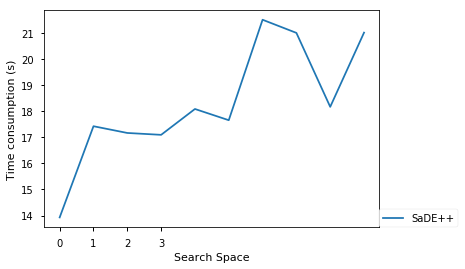

In [44]:
# plt.plot(Grid_times, label = 'GridSearchCV')
# plt.plot(Random_times, label = 'RandomisedSearchCV')
plt.plot(DE_times, label = 'SaDE++')
plt.legend(loc = [1, 0])
plt.xticks(range(0, 4))
plt.xlabel('Search Space')
plt.ylabel('Time consumption (s)')
plt.show()

In [52]:
print(Grid_paras)
print(Random_paras)
print(DE_paras)

[{'max_depth': 2, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}, {'max_depth': 4, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2}, {'max_depth': 6, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}, {'max_depth': 8, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 7}]
[{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 2}, {'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': None, 'max_depth': 4}, {'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None, 'max_depth': 6}, {'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 7}]
[{'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}, {'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}, {'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': None}, {'max_depth': 7, 'min_samples_split': 5,

In [74]:
Grid_scores = []
Random_scores = [] 
DE_scores = []

for i in range(len(Grid_paras)):
    paras = list(Grid_paras[i].values())
    print(paras)
    clf = RandomForestClassifier(max_depth = paras[0], max_features = paras[1], min_samples_leaf = paras[2], min_samples_split = paras[3], random_state = 1) 
    clf.fit(X_train, y_train)
    Grid_scores.append(clf.score(X_test, y_test))
    
    paras = list(Random_paras[i].values())
    print(paras)
    clf = RandomForestClassifier(max_depth = paras[3], max_features = paras[2], min_samples_leaf = paras[1], min_samples_split = paras[0], random_state = 1) 
    clf.fit(X_train, y_train)
    Random_scores.append(clf.score(X_test, y_test))
    
    paras = list(DE_paras[i].values())
    print(paras)
    clf = RandomForestClassifier(max_depth = paras[0], max_features = paras[3], min_samples_leaf = paras[2], min_samples_split = paras[1], random_state = 1) 
    clf.fit(X_train, y_train)
    DE_scores.append(clf.score(X_test, y_test))
    

[2, None, 1, 2]
[2, 1, None, 2]
[2, 2, 1, None]
[4, None, 3, 2]
[5, 3, None, 4]
[4, 5, 2, None]
[6, None, 2, 2]
[2, 3, None, 6]
[6, 3, 3, None]
[8, None, 3, 7]
[9, 1, None, 7]
[7, 5, 1, None]


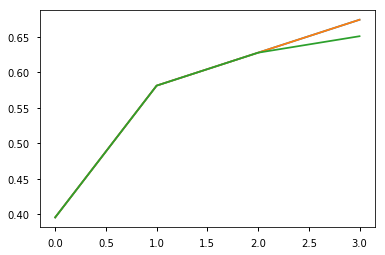

In [75]:
plt.plot(Grid_scores, label = 'GridSearchCV')
plt.plot(Random_scores, label = 'RandomisedSearchCV')
plt.plot(DE_scores, label = 'SaDE++')